In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

rnn_unit=10       #hidden layer units
input_size=3
output_size=1
lr=0.0006  
df = pd.read_csv('FB.csv') 
data=df.iloc[:,1:5].values
data

array([[ 117.419998,  117.599998,  115.940002,  115.970001],
       [ 116.239998,  117.730003,  116.120003,  117.699997],
       [ 118.129997,  118.669998,  117.379997,  117.889999],
       ..., 
       [ 183.490005,  184.190002,  182.610001,  182.679993],
       [ 183.770004,  185.300003,  183.130005,  184.490005],
       [ 184.929993,  185.419998,  183.429993,  183.800003]])

In [85]:
#Generate train data
def get_train_data(batch_size=60,time_step=20,train_begin=0,train_end=len(data)):
    batch_index=[]
    data_train=data[train_begin:train_end]
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  #标准化
    train_x,train_y=[],[]   #训练集
    for i in range(len(normalized_train_data)-time_step):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,:3]
        y=normalized_train_data[i:i+time_step,3,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

In [96]:
#获取测试集
def get_test_data(time_step=20,test_begin=480):
    data_test=data[test_begin:]
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  #标准化
    size=(len(normalized_test_data)+time_step-1)//time_step  #有size个sample
    test_x,test_y=[],[]
    for i in range(size-1):
        x=normalized_test_data[i*time_step:(i+1)*time_step,:3]
        y=normalized_test_data[i*time_step:(i+1)*time_step,3]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,:3]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,3]).tolist())
    return mean,std,test_x,test_y

In [97]:
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }


In [98]:
def lstm(X):
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    with tf.variable_scope("lstm"):
        cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
        init_state=cell.zero_state(batch_size,dtype=tf.float32)
        output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

In [106]:
def train_lstm(batch_size=60,time_step=20,train_begin=0,train_end=480):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step,train_begin,train_end)
    with tf.variable_scope("lstm", reuse=tf.AUTO_REUSE):
        pred,_=lstm(X)
        loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
        train_op=tf.train.AdamOptimizer(lr).minimize(loss)
        saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(1000):  
            #这个迭代次数，可以更改，越大预测效果会更好，但需要更长时间
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
                print(step);
            print("Number of iterations:",i," loss:",loss_)
        print("model_save: ",saver.save(sess,'model_save2\\modle.ckpt'))
        #我是在window下跑的，这个地址是存放模型的地方，模型参数文件名为modle.ckpt
        #在Linux下面用 'model_save2/modle.ckpt'
        print("The train has finished")


In [107]:
def prediction(time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope("lstm",reuse=True):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)-1):
            prob=sess.run(pred,feed_dict={X:[test_x[step]]})
            predict=prob.reshape((-1))
            test_predict.extend(predict)
        test_y=np.array(test_y)*std[3]+mean[3]
        test_predict=np.array(test_predict)*std[3]+mean[3]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差程度
        print("The accuracy of this predict:",acc)
        #以折线图表示结果
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b',)
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()

In [108]:
train_lstm()

0
1
2
3
4
5
6
7
Number of iterations: 0  loss: 2.01934
0
1
2
3
4
5
6
7
Number of iterations: 1  loss: 1.4078
0
1
2
3
4
5
6
7
Number of iterations: 2  loss: 0.938148
0
1
2
3
4
5
6
7
Number of iterations: 3  loss: 0.607435
0
1
2
3
4
5
6
7
Number of iterations: 4  loss: 0.39149
0
1
2
3
4
5
6
7
Number of iterations: 5  loss: 0.263924
0
1
2
3
4
5
6
7
Number of iterations: 6  loss: 0.197558
0
1
2
3
4
5
6
7
Number of iterations: 7  loss: 0.166523
0
1
2
3
4
5
6
7
Number of iterations: 8  loss: 0.151048
0
1
2
3
4
5
6
7
Number of iterations: 9  loss: 0.140227
0
1
2
3
4
5
6
7
Number of iterations: 10  loss: 0.130284
0
1
2
3
4
5
6
7
Number of iterations: 11  loss: 0.120807
0
1
2
3
4
5
6
7
Number of iterations: 12  loss: 0.112074
0
1
2
3
4
5
6
7
Number of iterations: 13  loss: 0.104146
0
1
2
3
4
5
6
7
Number of iterations: 14  loss: 0.0969134
0
1
2
3
4
5
6
7
Number of iterations: 15  loss: 0.0902625
0
1
2
3
4
5
6
7
Number of iterations: 16  loss: 0.0841397
0
1
2
3
4
5
6
7
Number of iterations: 17  

4
5
6
7
Number of iterations: 144  loss: 0.014714
0
1
2
3
4
5
6
7
Number of iterations: 145  loss: 0.0146356
0
1
2
3
4
5
6
7
Number of iterations: 146  loss: 0.0145579
0
1
2
3
4
5
6
7
Number of iterations: 147  loss: 0.0144808
0
1
2
3
4
5
6
7
Number of iterations: 148  loss: 0.0144045
0
1
2
3
4
5
6
7
Number of iterations: 149  loss: 0.0143288
0
1
2
3
4
5
6
7
Number of iterations: 150  loss: 0.0142537
0
1
2
3
4
5
6
7
Number of iterations: 151  loss: 0.0141793
0
1
2
3
4
5
6
7
Number of iterations: 152  loss: 0.0141056
0
1
2
3
4
5
6
7
Number of iterations: 153  loss: 0.0140325
0
1
2
3
4
5
6
7
Number of iterations: 154  loss: 0.01396
0
1
2
3
4
5
6
7
Number of iterations: 155  loss: 0.0138882
0
1
2
3
4
5
6
7
Number of iterations: 156  loss: 0.013817
0
1
2
3
4
5
6
7
Number of iterations: 157  loss: 0.0137464
0
1
2
3
4
5
6
7
Number of iterations: 158  loss: 0.0136764
0
1
2
3
4
5
6
7
Number of iterations: 159  loss: 0.013607
0
1
2
3
4
5
6
7
Number of iterations: 160  loss: 0.0135383
0
1
2
3
4


5
6
7
Number of iterations: 285  loss: 0.00858665
0
1
2
3
4
5
6
7
Number of iterations: 286  loss: 0.00856812
0
1
2
3
4
5
6
7
Number of iterations: 287  loss: 0.0085499
0
1
2
3
4
5
6
7
Number of iterations: 288  loss: 0.00853171
0
1
2
3
4
5
6
7
Number of iterations: 289  loss: 0.00851376
0
1
2
3
4
5
6
7
Number of iterations: 290  loss: 0.00849588
0
1
2
3
4
5
6
7
Number of iterations: 291  loss: 0.00847819
0
1
2
3
4
5
6
7
Number of iterations: 292  loss: 0.00846063
0
1
2
3
4
5
6
7
Number of iterations: 293  loss: 0.00844321
0
1
2
3
4
5
6
7
Number of iterations: 294  loss: 0.00842593
0
1
2
3
4
5
6
7
Number of iterations: 295  loss: 0.00840878
0
1
2
3
4
5
6
7
Number of iterations: 296  loss: 0.00839178
0
1
2
3
4
5
6
7
Number of iterations: 297  loss: 0.00837492
0
1
2
3
4
5
6
7
Number of iterations: 298  loss: 0.00835818
0
1
2
3
4
5
6
7
Number of iterations: 299  loss: 0.00834158
0
1
2
3
4
5
6
7
Number of iterations: 300  loss: 0.00832513
0
1
2
3
4
5
6
7
Number of iterations: 301  loss: 0.

4
5
6
7
Number of iterations: 424  loss: 0.0070612
0
1
2
3
4
5
6
7
Number of iterations: 425  loss: 0.0071143
0
1
2
3
4
5
6
7
Number of iterations: 426  loss: 0.00706163
0
1
2
3
4
5
6
7
Number of iterations: 427  loss: 0.00709283
0
1
2
3
4
5
6
7
Number of iterations: 428  loss: 0.00705786
0
1
2
3
4
5
6
7
Number of iterations: 429  loss: 0.00707979
0
1
2
3
4
5
6
7
Number of iterations: 430  loss: 0.00705096
0
1
2
3
4
5
6
7
Number of iterations: 431  loss: 0.00707008
0
1
2
3
4
5
6
7
Number of iterations: 432  loss: 0.00704261
0
1
2
3
4
5
6
7
Number of iterations: 433  loss: 0.00706175
0
1
2
3
4
5
6
7
Number of iterations: 434  loss: 0.00703356
0
1
2
3
4
5
6
7
Number of iterations: 435  loss: 0.00705427
0
1
2
3
4
5
6
7
Number of iterations: 436  loss: 0.00702403
0
1
2
3
4
5
6
7
Number of iterations: 437  loss: 0.0070477
0
1
2
3
4
5
6
7
Number of iterations: 438  loss: 0.00701405
0
1
2
3
4
5
6
7
Number of iterations: 439  loss: 0.0070424
0
1
2
3
4
5
6
7
Number of iterations: 440  loss: 0.0

1
2
3
4
5
6
7
Number of iterations: 563  loss: 0.00668669
0
1
2
3
4
5
6
7
Number of iterations: 564  loss: 0.00668392
0
1
2
3
4
5
6
7
Number of iterations: 565  loss: 0.00668144
0
1
2
3
4
5
6
7
Number of iterations: 566  loss: 0.00667864
0
1
2
3
4
5
6
7
Number of iterations: 567  loss: 0.0066762
0
1
2
3
4
5
6
7
Number of iterations: 568  loss: 0.00667335
0
1
2
3
4
5
6
7
Number of iterations: 569  loss: 0.00667097
0
1
2
3
4
5
6
7
Number of iterations: 570  loss: 0.00666806
0
1
2
3
4
5
6
7
Number of iterations: 571  loss: 0.00666577
0
1
2
3
4
5
6
7
Number of iterations: 572  loss: 0.00666275
0
1
2
3
4
5
6
7
Number of iterations: 573  loss: 0.0066606
0
1
2
3
4
5
6
7
Number of iterations: 574  loss: 0.00665741
0
1
2
3
4
5
6
7
Number of iterations: 575  loss: 0.00665547
0
1
2
3
4
5
6
7
Number of iterations: 576  loss: 0.00665201
0
1
2
3
4
5
6
7
Number of iterations: 577  loss: 0.00665041
0
1
2
3
4
5
6
7
Number of iterations: 578  loss: 0.00664652
0
1
2
3
4
5
6
7
Number of iterations: 579  l

6
7
Number of iterations: 700  loss: 0.0064571
0
1
2
3
4
5
6
7
Number of iterations: 701  loss: 0.0064291
0
1
2
3
4
5
6
7
Number of iterations: 702  loss: 0.00647917
0
1
2
3
4
5
6
7
Number of iterations: 703  loss: 0.00643791
0
1
2
3
4
5
6
7
Number of iterations: 704  loss: 0.00646042
0
1
2
3
4
5
6
7
Number of iterations: 705  loss: 0.0064433
0
1
2
3
4
5
6
7
Number of iterations: 706  loss: 0.00644766
0
1
2
3
4
5
6
7
Number of iterations: 707  loss: 0.00644657
0
1
2
3
4
5
6
7
Number of iterations: 708  loss: 0.00644336
0
1
2
3
4
5
6
7
Number of iterations: 709  loss: 0.00644411
0
1
2
3
4
5
6
7
Number of iterations: 710  loss: 0.0064402
0
1
2
3
4
5
6
7
Number of iterations: 711  loss: 0.00643943
0
1
2
3
4
5
6
7
Number of iterations: 712  loss: 0.00643624
0
1
2
3
4
5
6
7
Number of iterations: 713  loss: 0.00643441
0
1
2
3
4
5
6
7
Number of iterations: 714  loss: 0.00643152
0
1
2
3
4
5
6
7
Number of iterations: 715  loss: 0.00642925
0
1
2
3
4
5
6
7
Number of iterations: 716  loss: 0.00642

3
4
5
6
7
Number of iterations: 837  loss: 0.00617664
0
1
2
3
4
5
6
7
Number of iterations: 838  loss: 0.00617525
0
1
2
3
4
5
6
7
Number of iterations: 839  loss: 0.00617148
0
1
2
3
4
5
6
7
Number of iterations: 840  loss: 0.0061736
0
1
2
3
4
5
6
7
Number of iterations: 841  loss: 0.00616921
0
1
2
3
4
5
6
7
Number of iterations: 842  loss: 0.00618567
0
1
2
3
4
5
6
7
Number of iterations: 843  loss: 0.00619257
0
1
2
3
4
5
6
7
Number of iterations: 844  loss: 0.00627813
0
1
2
3
4
5
6
7
Number of iterations: 845  loss: 0.00637163
0
1
2
3
4
5
6
7
Number of iterations: 846  loss: 0.00684235
0
1
2
3
4
5
6
7
Number of iterations: 847  loss: 0.00735679
0
1
2
3
4
5
6
7
Number of iterations: 848  loss: 0.00989785
0
1
2
3
4
5
6
7
Number of iterations: 849  loss: 0.0111737
0
1
2
3
4
5
6
7
Number of iterations: 850  loss: 0.0150549
0
1
2
3
4
5
6
7
Number of iterations: 851  loss: 0.0110659
0
1
2
3
4
5
6
7
Number of iterations: 852  loss: 0.00841319
0
1
2
3
4
5
6
7
Number of iterations: 853  loss: 0

6
7
Number of iterations: 974  loss: 0.00599451
0
1
2
3
4
5
6
7
Number of iterations: 975  loss: 0.00599142
0
1
2
3
4
5
6
7
Number of iterations: 976  loss: 0.00598835
0
1
2
3
4
5
6
7
Number of iterations: 977  loss: 0.00598532
0
1
2
3
4
5
6
7
Number of iterations: 978  loss: 0.00598229
0
1
2
3
4
5
6
7
Number of iterations: 979  loss: 0.00597931
0
1
2
3
4
5
6
7
Number of iterations: 980  loss: 0.00597633
0
1
2
3
4
5
6
7
Number of iterations: 981  loss: 0.0059734
0
1
2
3
4
5
6
7
Number of iterations: 982  loss: 0.00597046
0
1
2
3
4
5
6
7
Number of iterations: 983  loss: 0.00596757
0
1
2
3
4
5
6
7
Number of iterations: 984  loss: 0.00596468
0
1
2
3
4
5
6
7
Number of iterations: 985  loss: 0.00596184
0
1
2
3
4
5
6
7
Number of iterations: 986  loss: 0.00595899
0
1
2
3
4
5
6
7
Number of iterations: 987  loss: 0.0059562
0
1
2
3
4
5
6
7
Number of iterations: 988  loss: 0.00595343
0
1
2
3
4
5
6
7
Number of iterations: 989  loss: 0.00595071
0
1
2
3
4
5
6
7
Number of iterations: 990  loss: 0.005

INFO:tensorflow:Restoring parameters from model_save2\modle.ckpt
The accuracy of this predict: 0.00732542188506


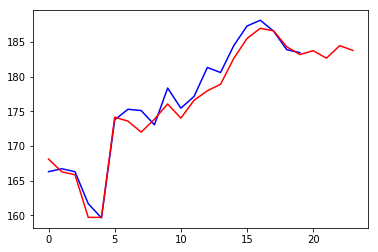

In [109]:
prediction()